In [1]:
import pandas as pd
import os
from pathlib import Path

# Path to the directory containing the 4 scenario folders
base_path = Path("/home/haasehelen/haasehelen/ifwaste/output")  # <-- UPDATE this
EXCLUDE_COLUMNS = ['n_quickcook', 'n_cook', 'n_attempted_cook', 'n_leftovers', 'n_shop',
    'n_quickshop', 'n_attempted_shop']

# Replace with your actual folder names if different
scenario_folders = ["scenario0_no_promotions", "scenario1_bogos_only", "scenario2_sales_only", "scenario3_both"]
#scenario_folders = ["scenario0_no_promotions", "scenario3_both"]
# Dictionary to hold combined dataframes per scenario
scenario_data = {}

for scenario in scenario_folders:
    scenario_path = base_path / scenario
    combined_rows = []
    print(scenario_path)
    # Loop through each subfolder starting with 'run_'
    for run_folder in scenario_path.glob("run_*"):
        run_id = run_folder.name.split("_")[1]  # Extract ID from 'run_<id>'
        
        config_file = run_folder / "log_hh_config.csv"
        output_file = run_folder / "aggregated_outputs.csv"
        bought_file = run_folder / "log_bought.csv"
        

        # Check both files exist
        if not config_file.exists() or not output_file.exists() or not bought_file.exists():
            print(f"Skipping {run_folder} due to missing files.")
            continue

        # Load CSVs
        try:
            df_config = pd.read_csv(config_file)
            df_output = pd.read_csv(output_file)
            df_bought = pd.read_csv(bought_file)
        except Exception as e:
            print(f"Error reading files in {run_folder}: {e}")
            continue

        
        
        merged_df = pd.merge(df_config, df_output, on="household", how="inner")

        # Add unique key
        merged_df["run_household_key"] = merged_df["household"].apply(lambda x: f"run_{run_id}_{x}")
        merged_df = merged_df.drop(columns=EXCLUDE_COLUMNS)  
        combined_rows.append(merged_df)
        
        #bought files
        df_bought["run_household_key"] = df_bought["household"].apply(lambda x: f"run_{run_id}_{x}")

    # Combine all merged rows for the scenario
    if combined_rows:
        scenario_data[scenario] = {}
        scenario_data[scenario]["general"] = pd.concat(combined_rows, ignore_index=True)
        scenario_data[scenario]["bought"] = df_bought
        print(f"{scenario}: Combined {len(combined_rows)} runs.")
    else:
        print(f"{scenario}: No valid data found.")



/home/haasehelen/haasehelen/ifwaste/output/scenario0_no_promotions
scenario0_no_promotions: Combined 16 runs.
/home/haasehelen/haasehelen/ifwaste/output/scenario1_bogos_only
scenario1_bogos_only: Combined 16 runs.
/home/haasehelen/haasehelen/ifwaste/output/scenario2_sales_only
scenario2_sales_only: Combined 16 runs.
/home/haasehelen/haasehelen/ifwaste/output/scenario3_both
scenario3_both: Combined 16 runs.


# Bought Servings Per Scenario

F-statistic: 48.6462
P-value: 0.0000


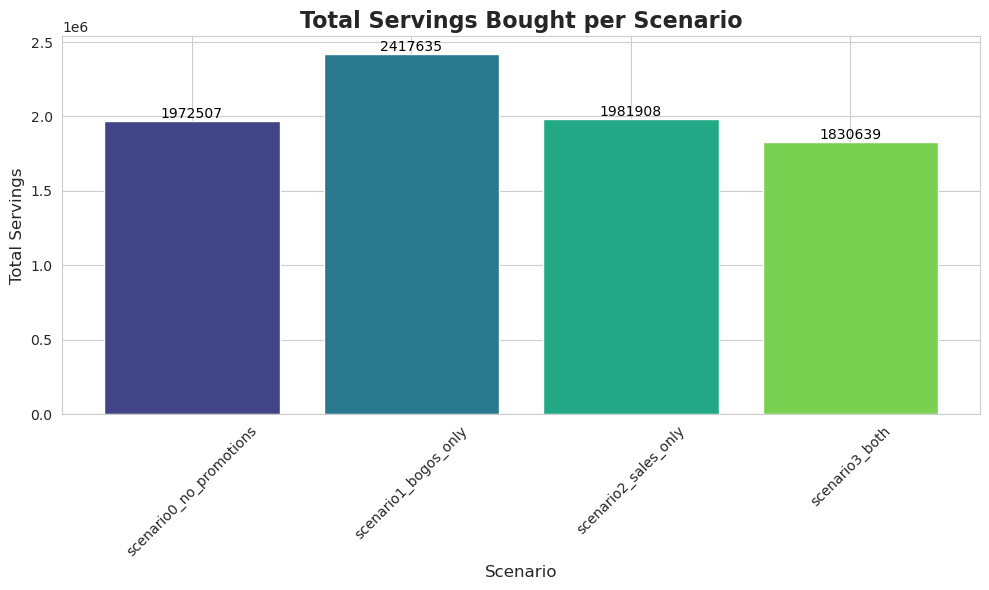

/scratch/local/10041665/ipykernel_2048528/658186305.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Scenario', y='Servings', data=boxplot_df, palette="viridis")


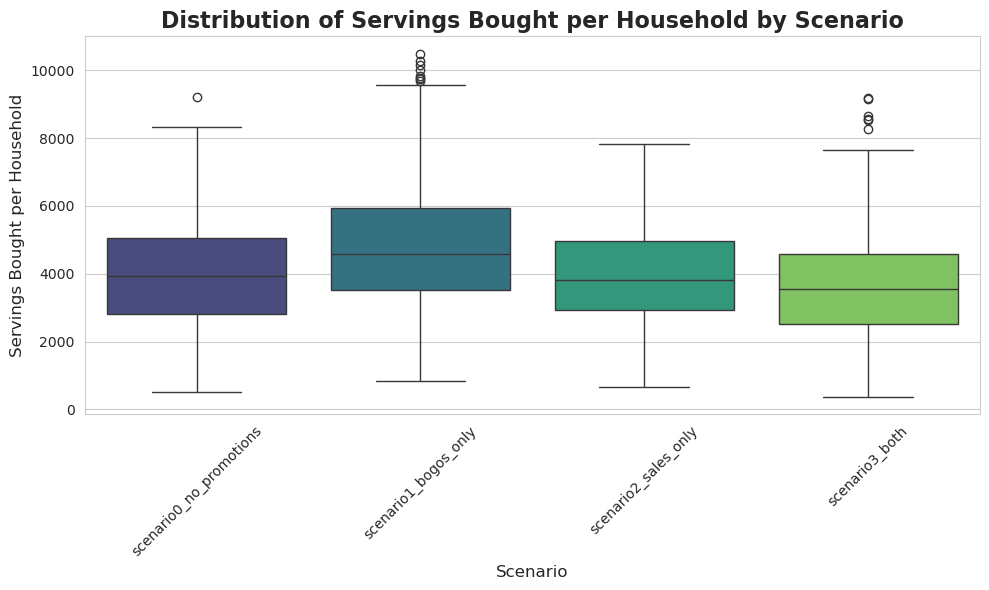

In [2]:
    
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import pandas as pd
import seaborn as sns # Import Seaborn for stayling

bought_dict = {}
for scenario in scenario_folders:
    bought_per_household = scenario_data[scenario]["bought"].groupby("run_household_key")["servings"].sum()
    bought_dict[scenario] = bought_per_household

total_servings_bought = []
for scenario in scenario_folders:
    total_servings_bought.append(scenario_data[scenario]["bought"]["servings"].sum())

f_statistic, p_value = stats.f_oneway(*bought_dict.values()) #anova one way

print(f"F-statistic: {f_statistic:.4f}")
print(f"P-value: {p_value:.4f}")

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(scenario_folders, total_servings_bought, color=sns.color_palette("viridis", len(scenario_folders)))
ax.set_title('Total Servings Bought per Scenario', fontsize=16, fontweight='bold')
ax.set_xlabel('Scenario', fontsize=12)
ax.set_ylabel('Total Servings', fontsize=12)
ax.tick_params(axis='x', labelrotation=45)

for bar in bars:
    yval = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2, 
        yval + 1,  # A small offset above the bar
        int(yval),  # Display the value as an integer
        ha='center', 
        va='bottom', 
        fontsize=10, 
        color='black'
    )

plt.tight_layout()
plt.show()


bought_dict = {}
for scenario in scenario_folders:
    bought_per_household = scenario_data[scenario]["bought"].groupby("run_household_key")["servings"].sum()
    bought_dict[scenario] = bought_per_household

# This section creates the boxplot.
# It first converts the dictionary of servings per household into a long-form DataFrame
# which is the preferred format for Seaborn plotting.
data_for_boxplot = []
for scenario, servings_data in bought_dict.items():
    temp_df = pd.DataFrame({'Scenario': scenario, 'Servings': servings_data})
    data_for_boxplot.append(temp_df)

if data_for_boxplot:
    boxplot_df = pd.concat(data_for_boxplot)
    
    sns.set_style("whitegrid")
    
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Scenario', y='Servings', data=boxplot_df, palette="viridis")
    plt.title('Distribution of Servings Bought per Household by Scenario', fontsize=16, fontweight='bold')
    plt.xlabel('Scenario', fontsize=12)
    plt.ylabel('Servings Bought per Household', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("The bought_dict is empty or not in the expected format.")

In [3]:

fg_names = ["FGMEAT","FGDAIRY","FGVEGETABLE","FGDRYFOOD","FGBAKED","FGSNACKS","FGSTOREPREPARED"]

lookup_df = pd.DataFrame({
    'Fg_name' : fg_names,
    'Servings_to_kg': [0.089, 0.146, 0.112, 0.076, 0.055, 0.071, 0.100],
    #"Color": ["#41afaa", "#00a0e1", "#466eb4", "#e6a532", "#d7642c","#af4b91"]
    "Color": ["#FFC446","#D66D10","#A40E4C","#2C2C54","#638EB5","#2F8550","#2C4A26"]
})
for scenario in scenario_folders:
    bought = scenario_data[scenario]["bought"]
    bought["Total_Kg"] = 0

    for food in fg_names:
        conversion_factor = lookup_df.loc[lookup_df["Fg_name"] == food, "Servings_to_kg"].values[0]
        bought["kg"] = bought[bought["type"] == food] * conversion_factor * bought["servings"] * bought["amount"]

# Create dict with total bought kg per household grouped by run_household_key
bought_dict = {}
for scenario in scenario_folders:
    bought = scenario_data[scenario]["bought"]
    bought_per_household_kg = bought.groupby("run_household_key")["Total_Kg"].sum()
    bought_dict[scenario] = bought_per_household_kg

# Calculate total kg bought per scenario (sum over households)
total_kg_bought = [bought.sum() for bought in bought_dict.values()]

# Barplot total bought kg per scenario
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(scenario_folders, total_kg_bought, color=sns.color_palette("viridis", len(scenario_folders)))
ax.set_title('Total Weight Bought per Scenario (kg)', fontsize=16, fontweight='bold')
ax.set_xlabel('Scenario', fontsize=12)
ax.set_ylabel('Total Weight (kg)', fontsize=12)
ax.tick_params(axis='x', labelrotation=45)

for bar in bars:
    yval = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        yval + 0.05 * max(total_kg_bought),
        f"{yval:.1f}",
        ha='center',
        va='bottom',
        fontsize=10,
        color='black'
    )

plt.tight_layout()
plt.show()

# Boxplot per household total bought kg per scenario
data_for_boxplot = []
for scenario, kg_data in bought_dict.items():
    temp_df = pd.DataFrame({'Scenario': scenario, 'Weight_kg': kg_data})
    data_for_boxplot.append(temp_df)

if data_for_boxplot:
    boxplot_df = pd.concat(data_for_boxplot)
    sns.set_style("whitegrid")

    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Scenario', y='Weight_kg', data=boxplot_df, palette="viridis")
    plt.title('Distribution of Weight Bought per Household by Scenario (kg)', fontsize=16, fontweight='bold')
    plt.xlabel('Scenario', fontsize=12)
    plt.ylabel('Weight Bought per Household (kg)', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("The bought_dict is empty or not in the expected format.")


TypeError: can't multiply sequence by non-int of type 'float'

In [ ]:
# Combine dataframes into a single, unified DataFrame
combined_dfs = []
for scenario_name in scenario_folders:
    df = scenario_data[scenario_name]["bought"]
    # Add a 'scenario' column to each DataFrame before combining
    df = df.assign(scenario=scenario_name)
    combined_dfs.append(df)
combined_df = pd.concat(combined_dfs, ignore_index=True)

In [ ]:
combined_df.head()

,household,day,type,servings,days_till_expiry,price_per_serving,sale_type,discount_effect,amount,sale_timer,store,product_ID,run_household_key,scenario
0,137,0,FGBAKED,2,8,0.48,EnumSales.NONE,EnumDiscountEffect.NONE,5,1000,"Discount_retailer at (13, 12)",FGBAKED20.48,run_9_137,02_scenario0_no_promotions
1,137,0,FGBAKED,4,8,0.40,EnumSales.NONE,EnumDiscountEffect.NONE,16,1000,"Discount_retailer at (13, 12)",FGBAKED40.4,run_9_137,02_scenario0_no_promotions
2,137,0,FGBAKED,6,8,0.32,EnumSales.NONE,EnumDiscountEffect.NONE,10,1000,"Discount_retailer at (13, 12)",FGBAKED60.32,run_9_137,02_scenario0_no_promotions
3,137,0,FGDAIRY,1,24,0.75,EnumSales.NONE,EnumDiscountEffect.NONE,2,1000,"Convenience_store at (13, 19)",FGDAIRY10.75,run_9_137,02_scenario0_no_promotions
4,137,0,FGDAIRY,2,24,0.60,EnumSales.NONE,EnumDiscountEffect.NONE,2,1000,"Discount_retailer at (13, 12)",FGDAIRY20.6,run_9_137,02_scenario0_no_promotions


# Bought Servings Per Scenario Per Category

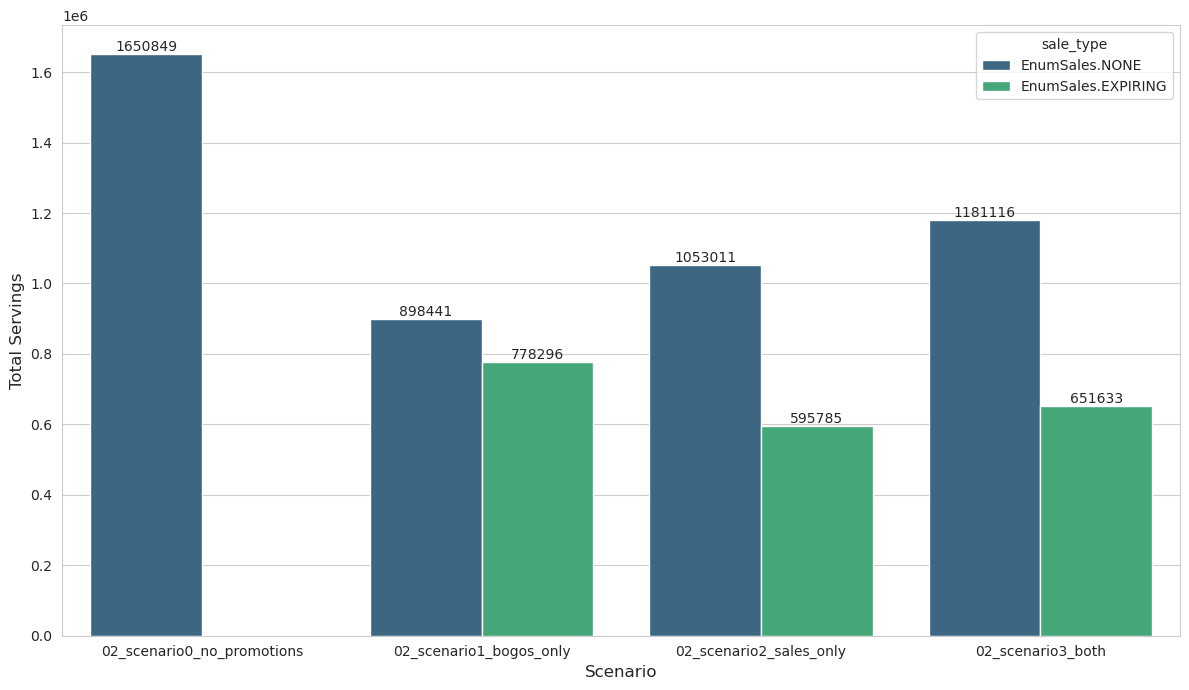

/scratch/local/9908470/ipykernel_3218129/1743306901.py:44: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_df_complete['servings'].fillna(0, inplace=True)


--- Two-Way ANOVA Results ---
                                sum_sq         df             F    PR(>F)
C(scenario)              -3.401587e-06        3.0 -2.904023e-07  1.000000
C(sale_type)             -1.752594e-07        1.0 -4.488705e-08  1.000000
C(scenario):C(sale_type)  2.508991e+00        3.0  2.141990e-01  0.643496
Residual                  7.975214e+06  2042594.0           NaN       NaN


/blue/carpena/haasehelen/.conda/envs/ifwaste-env/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  warnings.warn('covariance of constraints does not have full '


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols

def plot_and_two_way_anova(type:str):
    # Group the data to get total servings per scenario and type
    plot_df = combined_df.groupby(['scenario', type])['servings'].sum().reset_index()

    # --- Plotting ---
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=(12, 7))

    # Create the grouped bar plot using Seaborn's barplot
    bars = sns.barplot(
        x='scenario',
        y='servings',
        hue=type,  # This parameter creates the grouped bars
        data=plot_df,
        palette="viridis",
        ax=ax
    )

    # Set titles and labels for clarity
    ax.set_xlabel('Scenario', fontsize=12)
    ax.set_ylabel('Total Servings', fontsize=12)

    # Add value labels on top of each bar
    for container in ax.containers:
        ax.bar_label(container, fmt='%d', label_type='edge', fontsize=10)

    plt.tight_layout()
    plt.show()

    # We need to make sure the combined_df has all combinations before running the ANOVA
    # A more robust approach is to add rows with 0 servings for missing combinations
    factors = combined_df[type].unique()
    full_data_index = pd.MultiIndex.from_product([scenario_folders, factors], names=['scenario', type])
    full_df = pd.DataFrame(index=full_data_index).reset_index()
    combined_df_complete = pd.merge(full_df, combined_df, on=['scenario', type], how='left')
    combined_df_complete['servings'].fillna(0, inplace=True)
  
    # Perform a two-way ANOVA using statsmodels
    # The formula `servings ~ C(scenario) + C(type) + C(scenario):C(type)`
    # tests for the main effects of scenario and type, as well as their interaction.
    model = ols('servings ~ C(scenario) + C('+type+') + C(scenario):C('+type+')', data=combined_df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)

    print("--- Two-Way ANOVA Results ---")
    print(anova_table)
plot_and_two_way_anova("sale_type")

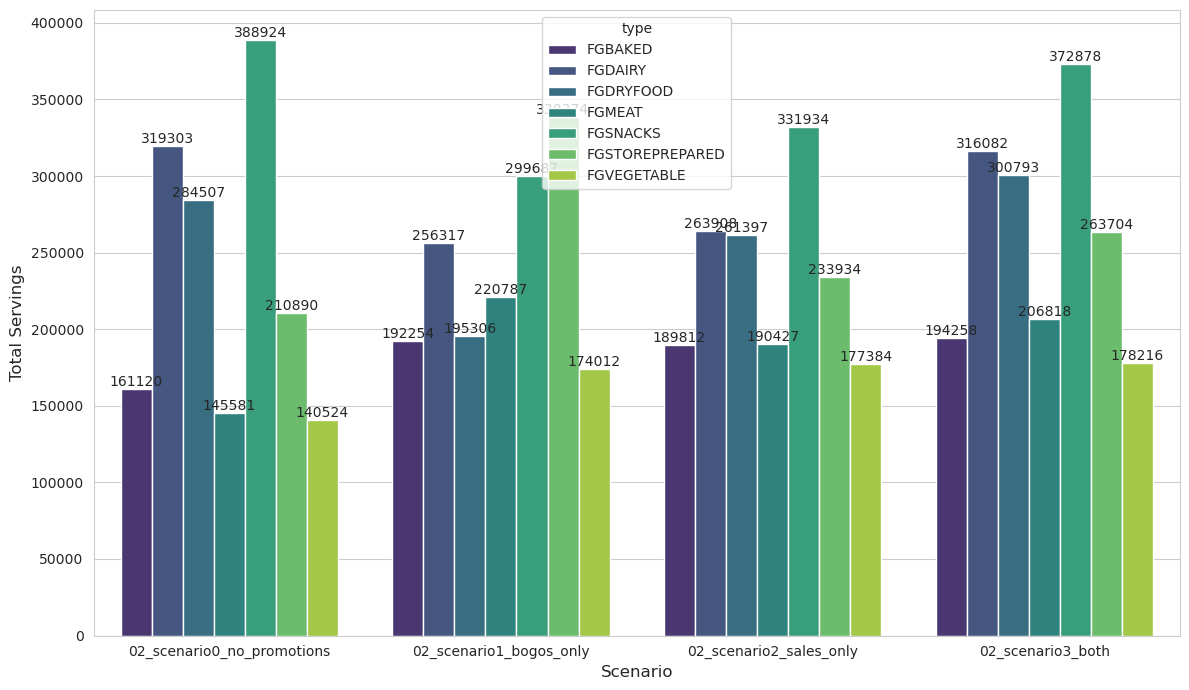

/scratch/local/9908470/ipykernel_3218129/1743306901.py:44: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_df_complete['servings'].fillna(0, inplace=True)


--- Two-Way ANOVA Results ---
                           sum_sq         df             F  PR(>F)
C(scenario)          1.207620e+05        3.0   9999.330893     0.0
C(type)              5.916037e+05        6.0  24492.971611     0.0
C(scenario):C(type)  3.918621e+05       18.0   5407.825305     0.0
Residual             8.222724e+06  2042573.0           NaN     NaN


: 

In [ ]:
plot_and_two_way_anova("type")

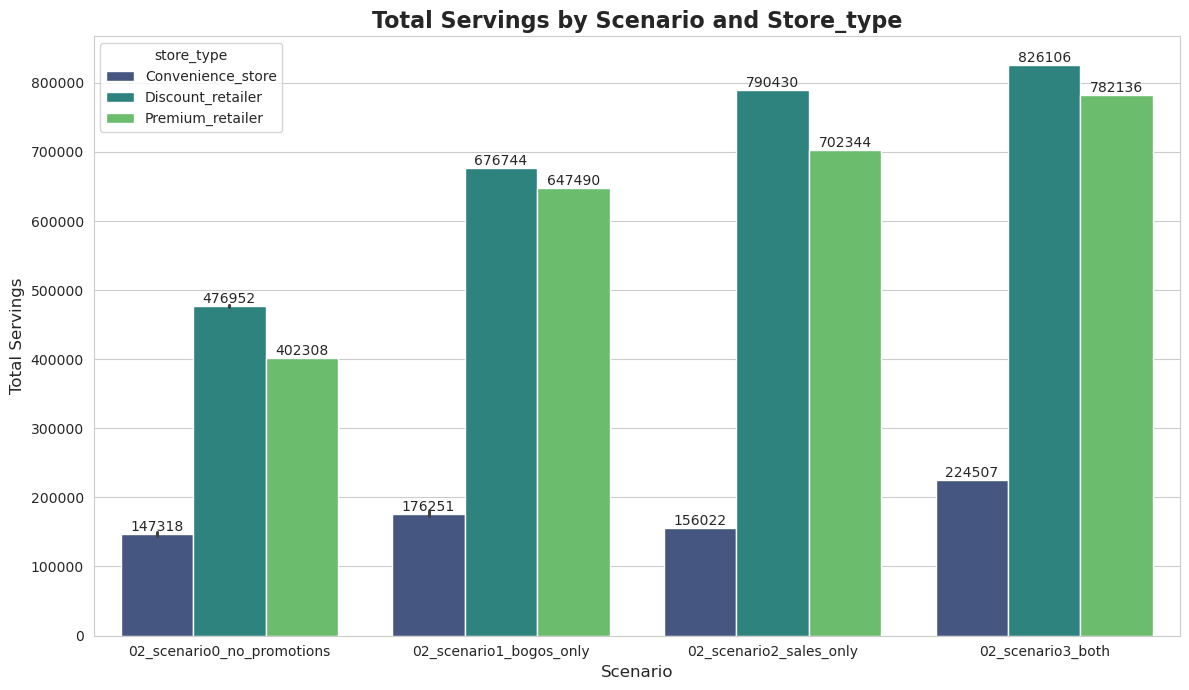

/scratch/local/9908470/ipykernel_3218129/3720405070.py:55: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_df_complete['servings'].fillna(0, inplace=True)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Define the function with the added logic
def plot_and_two_way_anova(type: str):
   
    # --- Prepare data for plotting ---
    # Group the data to get total servings per scenario and type
    plot_df = combined_df.groupby(['scenario', type])['servings'].sum().reset_index()

    # Determine which column to use for the bar hue
    hue_column = type
    if type == 'store':
        # If the type is 'store', extract the store type from the full name
        # The store name format is assumed to be 'Store_Type at (x, y)'
        plot_df['store_type'] = plot_df[type].apply(lambda x: x.split(' ')[0])
        hue_column = 'store_type'

    # --- Plotting ---
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=(12, 7))

    # Create the grouped bar plot using Seaborn's barplot
    bars = sns.barplot(
        x='scenario',
        y='servings',
        hue=hue_column,  # Use the determined hue_column
        data=plot_df,
        palette="viridis",
        ax=ax
    )

    # Add titles and labels for clarity
    ax.set_xlabel('Scenario', fontsize=12)
    ax.set_ylabel('Total Servings', fontsize=12)
    plt.title(f'Total Servings by Scenario and {hue_column.capitalize()}', fontsize=16, fontweight='bold')
    
    # Add value labels on top of each bar
    for container in ax.containers:
        ax.bar_label(container, fmt='%d', label_type='edge', fontsize=10)

    plt.tight_layout()
    plt.show()

    # --- Perform Two-Way ANOVA ---
    # We need to make sure the combined_df has all combinations before running the ANOVA
    factors = combined_df[type].unique()
    full_data_index = pd.MultiIndex.from_product([scenario_folders, factors], names=['scenario', type])
    full_df = pd.DataFrame(index=full_data_index).reset_index()
    combined_df_complete = pd.merge(full_df, combined_df, on=['scenario', type], how='left')
    combined_df_complete['servings'].fillna(0, inplace=True)
 
    # Perform a two-way ANOVA using statsmodels
    # The formula `servings ~ C(scenario) + C(type) + C(scenario):C(type)`
    # tests for the main effects of scenario and type, as well as their interaction.
    # Note: ANOVA is performed on the original 'type' column, not the simplified 'store_type'.
    model = ols(f'servings ~ C(scenario) + C({type}) + C(scenario):C({type})', data=combined_df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)

    print("--- Two-Way ANOVA Results ---")
    print(anova_table)

# Example usage (you will need to replace this with your actual data)
# combined_df = pd.DataFrame(...)
# scenario_folders = ['scenario1', 'scenario2', 'scenario3']
plot_and_two_way_anova("store")
# plot_and_two_way_anova("sale_type", combined_df, scenario_folders)


In [ ]:
#TODO add somestuff based on quickshop
#what is based on quickshop vs normal shop
#spending 

## Budget based 

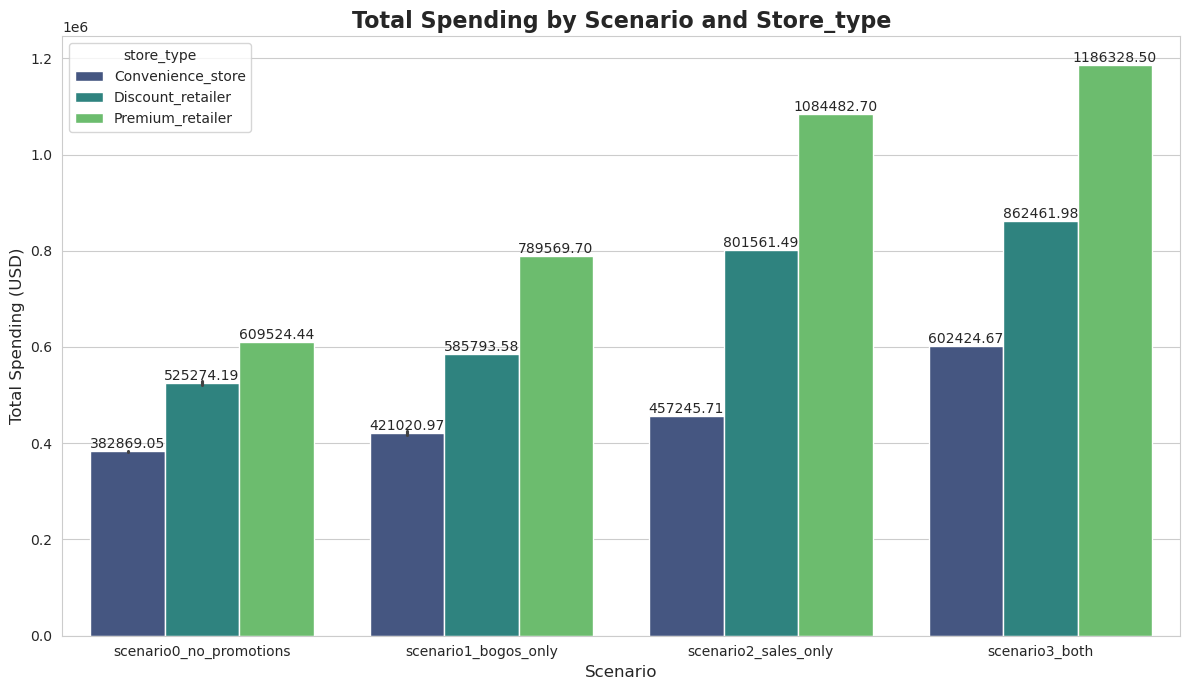

/scratch/local/9908470/ipykernel_2769615/4126639191.py:51: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_df_complete['cost'].fillna(0, inplace=True)


: 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols

def plot_spending_by_type(type_col: str, combined_df: pd.DataFrame):
    # Calculate cost
    combined_df = combined_df.copy()
    combined_df["cost"] = combined_df["servings"] * combined_df["price_per_serving"]

    # Aggregate spending per scenario & type
    plot_df = combined_df.groupby(['scenario', type_col])['cost'].sum().reset_index()

    # If we're working with stores, extract store type from full name
    hue_column = type_col
    if type_col == 'store':
        plot_df['store_type'] = plot_df[type_col].apply(lambda x: x.split(' ')[0])
        hue_column = 'store_type'

    # --- Plotting ---
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=(12, 7))

    bars = sns.barplot(
        x='scenario',
        y='cost',
        hue=hue_column,
        data=plot_df,
        palette="viridis",
        ax=ax
    )

    ax.set_xlabel('Scenario', fontsize=12)
    ax.set_ylabel('Total Spending (USD)', fontsize=12)
    plt.title(f'Total Spending by Scenario and {hue_column.capitalize()}', fontsize=16, fontweight='bold')

    # Add value labels
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=10)

    plt.tight_layout()
    plt.show()
    
    print("--- Two-Way ANOVA Results ---")
    print(anova_table)
plot_spending_by_type("store", combined_df)

/scratch/local/9908470/ipykernel_2769615/161762407.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_df, x="scenario", y="cost", palette="Set2")
/scratch/local/9908470/ipykernel_2769615/161762407.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(data=mean_spending, x="scenario", y="cost", palette="Set2")


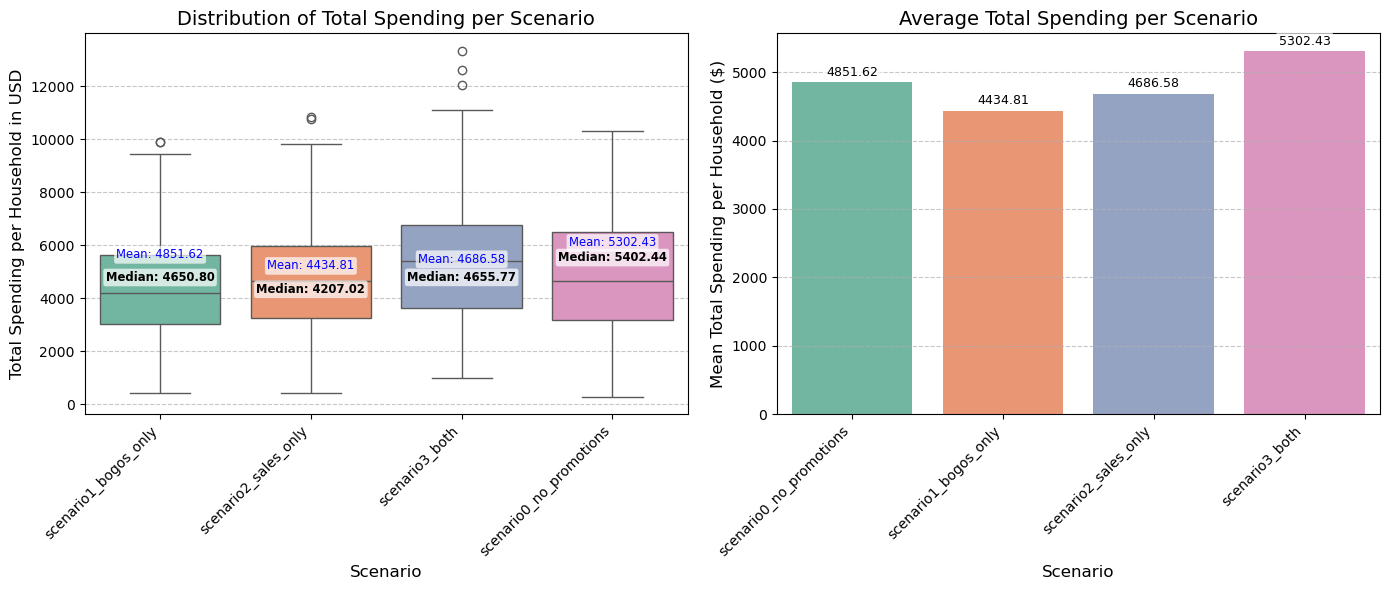

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols

def plot_spending(df):
    # 1️⃣ Calculate cost
    df["cost"] = df["servings"] * df["price_per_serving"]

    # 2️⃣ Aggregate to total spending per household per scenario
    plot_df = df.groupby(["run_household_key", "scenario"], as_index=False)["cost"].sum()

    plt.figure(figsize=(14, 6))

    # --- Boxplot with Summary Statistics ---
    plt.subplot(1, 2, 1)
    sns.boxplot(data=plot_df, x="scenario", y="cost", palette="Set2")
    plt.title("Distribution of Total Spending per Scenario", fontsize=14)
    plt.xlabel("Scenario", fontsize=12)
    plt.ylabel("Total Spending per Household in USD", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Summary stats
    medians = plot_df.groupby('scenario')['cost'].median().values
    means = plot_df.groupby('scenario')['cost'].mean().values
    xtick_locations = plt.gca().get_xticks()
    text_y_offset = (plot_df['cost'].max() - plot_df['cost'].min()) * 0.05

    for i, scenario_name in enumerate(plot_df['scenario'].unique()):
        median_val = medians[i]
        mean_val = means[i]

        plt.text(xtick_locations[i], median_val,
                f'Median: {median_val:.2f}',
                ha='center', size='small', color='black', weight='semibold',
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.2'))

        plt.text(xtick_locations[i], mean_val + text_y_offset,
                f'Mean: {mean_val:.2f}',
                ha='center', size='small', color='blue',
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.2'))

    # --- Barplot with Mean Values ---
    plt.subplot(1, 2, 2)
    mean_spending = plot_df.groupby("scenario")["cost"].mean().reset_index()
    bars = sns.barplot(data=mean_spending, x="scenario", y="cost", palette="Set2")

    for bar in bars.patches:
        yval = bar.get_height()
        offset = 0.01 * plt.gca().get_ylim()[1]
        plt.text(bar.get_x() + bar.get_width()/2, yval + offset,
                f'{yval:.2f}',
                ha='center', va='bottom', fontsize=9, color='black',
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.2'))

    plt.title("Average Total Spending per Scenario", fontsize=14)
    plt.xlabel("Scenario", fontsize=12)
    plt.ylabel("Mean Total Spending per Household ($)", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()
plot_spending(combined_df)